# Data Visualization - Fórmula 1

Este notebook carrega os CSVs de Data Layer/raw/dados_originais, trata lap_times.csv como fato e as demais como dimensões, e gera gráficos de barras, pizza, regressão e análise de outliers.

### Configuração do ambiente (Spark/Java)
- - Objetivo: preparar ambiente visual e garantir Java 17 + sessão Spark local.
- - Ações: aplica tema gráfico, força `JAVA_HOME` e configura `PATH`.
- - Saída: variáveis de ambiente setadas e `spark` (construtor) pronto.
- - Observação: unidades nos gráficos em segundos (s).

In [110]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import seaborn as sns
import pyspark.sql.functions as F
from matplotlib.ticker import MaxNLocator
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, stddev, col, avg, concat_ws, min, rank, when
from pyspark.sql.window import Window
os.environ['HADOOP_HOME'] = 'C:\\hadoop'
sys.path.append('C:\\hadoop\\bin')
spark = SparkSession.builder.appName('AnaliseETL-DataViz').master('local[*]').config('spark.driver.host', '127.0.0.1').getOrCreate()

### Carregamento dos dados (CSV → Spark DataFrames)  
- **Objetivo:** carregar arquivos originais para análise.  
- **Ações:** define base path e lê todos os `.csv` com inferência de schema.  
- **Saída:** dicionário `dataframes` com 10 tabelas carregadas.  


In [111]:
base_path = 'C:/Users/julii/OneDrive/Documentos/formula1-analytics/Data Layer/raw/dados_originais'
file_names = ['circuits', 'constructors', 'drivers', 'lap_times', 'pit_stops', 'qualifying', 'races', 'results', 'status', 'sprint_results']
dataframes = {}
try:
    for name in file_names:
        file_path = f'{base_path}/{name}.csv'
        dataframes[name] = spark.read.csv(file_path, header=True, inferSchema=True, nullValue='\\N')
except Exception as e:
    print(f'\nERRO AO CARREGAR OS ARQUIVOS. Verifique o caminho base.')
    spark.stop()
    exit()

- **Objetivo do gráfico:** Visualizar o ranking dos 20 pilotos com menor tempo médio de volta em toda a base histórica.
- **Dados utilizados:** `lap_times` para tempos por volta e `drivers` para montar o nome completo de cada piloto.
- **Ações principais:** Inicializa a SparkSession local; lê os CSVs cadastrados em `file_names` para o dicionário `dataframes`; agrega o tempo médio por piloto; converte o resultado para segundos e para Pandas; monta o gráfico de barras horizontal destacando os 20 melhores.
- **Saída:** Figura `Tempo Médio de Volta por Piloto (Top 20)` em Matplotlib e impressão do piloto líder em tempo médio.
- **Insight esperado:** Identificar quem mantém o ritmo mais rápido de forma consistente, base para comparações entre pilotos.
- **Observações técnicas:** A configuração do ambiente e o dicionário `dataframes` são reutilizados por todas as células posteriores.


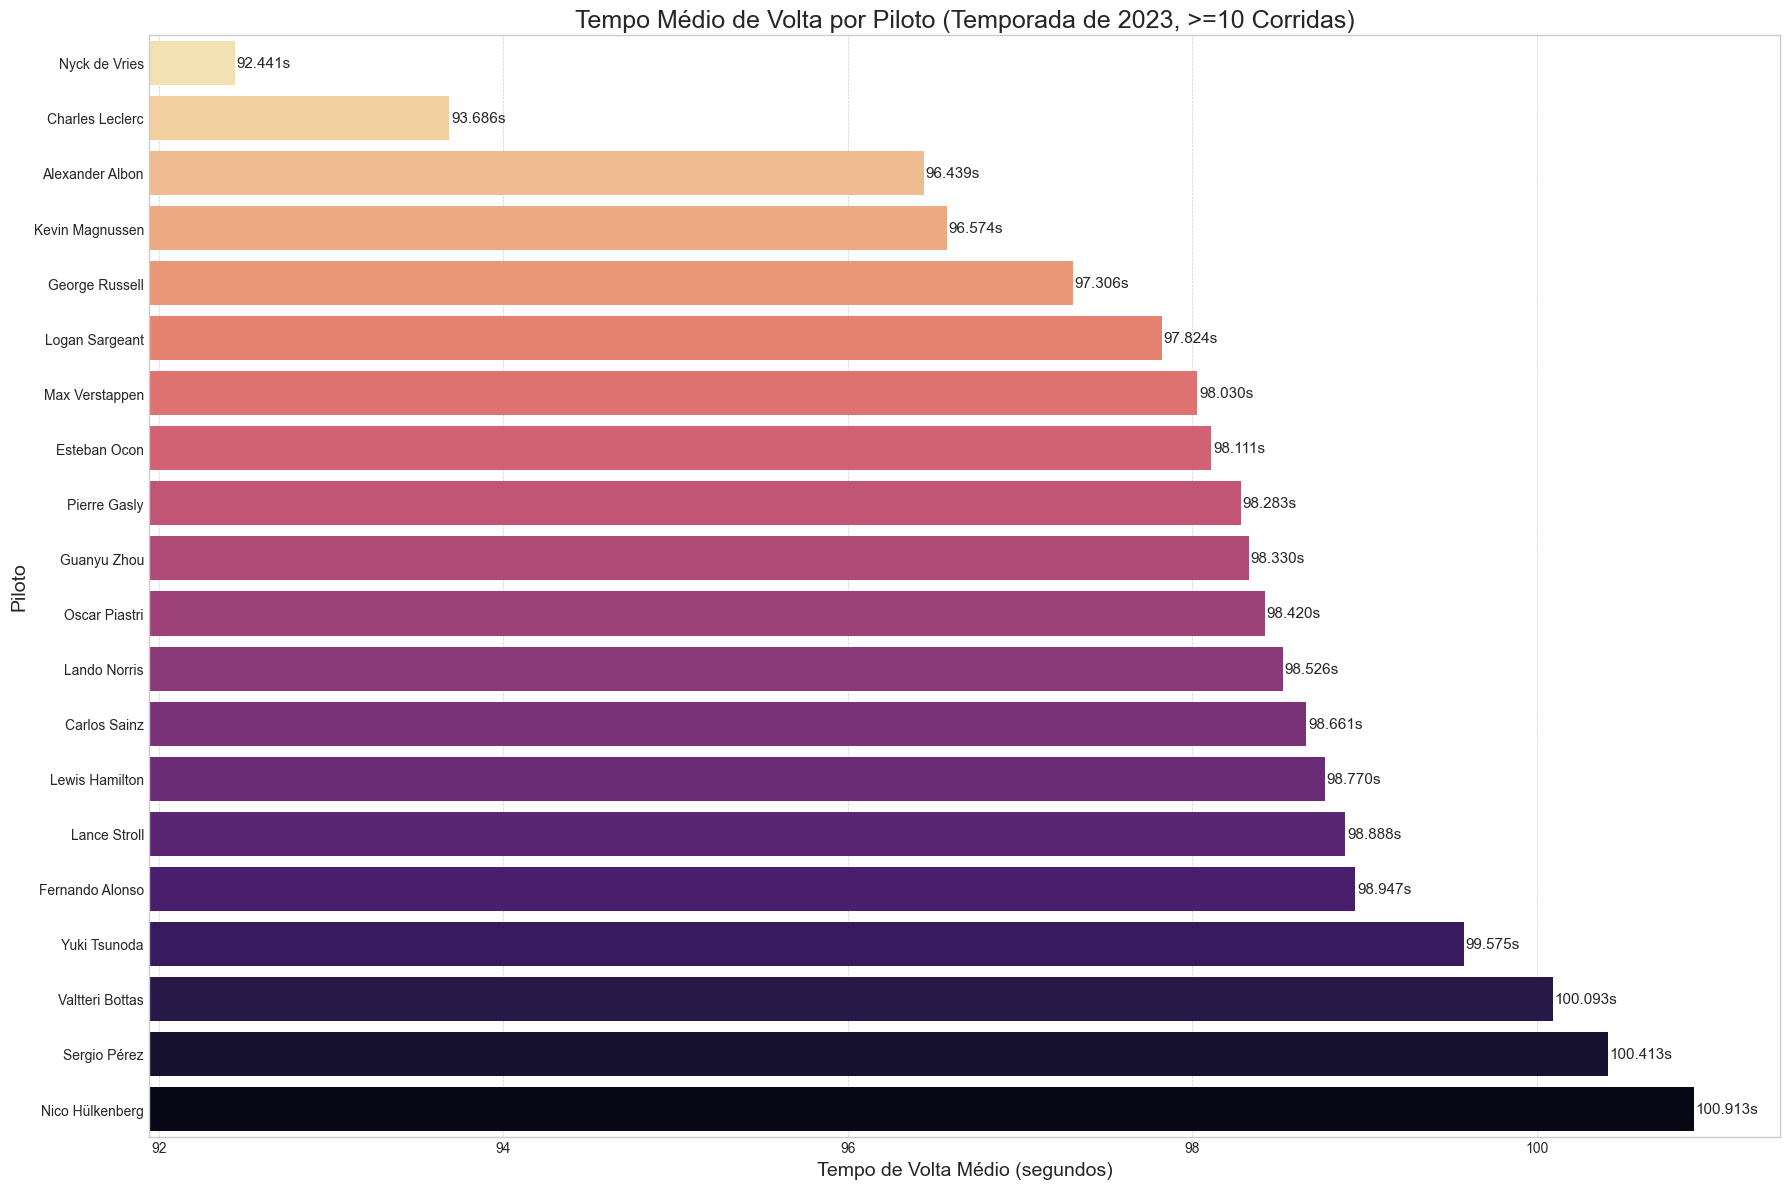

Na temporada de 2023 (considerando pilotos com >=10 corridas), o piloto mais rápido em média foi Nyck de Vries com um tempo de 92.441 segundos.


In [112]:
target_season_year = 2023

season_races = dataframes['races'].filter(col("year") == target_season_year).select("raceId")

season_results = dataframes['results'].join(season_races, "raceId", "inner")

races_per_driver = season_results.groupBy("driverId") \
    .agg(count("raceId").alias("races_participated"))

full_season_drivers = races_per_driver.filter(col("races_participated") >= 10).select("driverId")

season_lap_times = dataframes['lap_times'].join(season_races, "raceId", "inner")

filtered_lap_times = season_lap_times.join(full_season_drivers, "driverId", "inner")

avg_lap_time_df = filtered_lap_times.groupBy('driverId').agg(avg('milliseconds').alias('avg_milliseconds'))

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
avg_lap_time_with_driver = avg_lap_time_df.join(drivers_with_label, 'driverId') \
    .withColumn('avg_seconds', col('avg_milliseconds') / 1000) \
    .orderBy('avg_seconds')

plot_data_season_filtered = avg_lap_time_with_driver.select('driver_name', 'avg_seconds').toPandas()

plt.figure(figsize=(18, 12))
ax = sns.barplot(
    x='avg_seconds',
    y='driver_name',
    data=plot_data_season_filtered,
    orient='h',
    palette='magma_r',
    hue='driver_name',
    legend=False
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.01,
        p.get_y() + p.get_height() / 2.,
        f'{width:.3f}s',
        va='center',
        fontsize=11
    )

plt.title(f'Tempo Médio de Volta por Piloto (Temporada de {target_season_year}, >=10 Corridas)', fontsize=18)
plt.xlabel('Tempo de Volta Médio (segundos)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)

min_time = plot_data_season_filtered['avg_seconds'].min()
max_time = plot_data_season_filtered['avg_seconds'].max()
plt.xlim(left=min_time - 0.5, right=max_time + 0.5)

plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()
plt.show()

fastest_driver_season = plot_data_season_filtered.iloc[0]
print(f"Na temporada de {target_season_year} (considerando pilotos com >=10 corridas), o piloto mais rápido em média foi {fastest_driver_season['driver_name']} com um tempo de {fastest_driver_season['avg_seconds']:.3f} segundos.")

### Voltas recordes por corrida


- **Objetivo do gráfico:** Descobrir quais corridas registraram as voltas mais rápidas da história.
- **Dados utilizados:** `lap_times` para calcular o menor tempo por corrida e `races` para compor o rótulo nome + ano.
- **Ações principais:** Agrupa as voltas por `raceId` pegando o tempo mínimo; junta com os metadados da corrida; converte tempos para segundos; ordena da volta mais rápida para a mais lenta; cria o gráfico de barras horizontal com o Top 20.
- **Saída:** Figura `Volta Mais Rápida por Corrida (Top 20)` e mensagem no console apontando a prova com volta mais veloz.
- **Insight esperado:** Evidenciar eventos com condições excepcionais de desempenho, úteis para análises comparativas por temporada ou circuito.
- **Complemento útil:** Permite correlacionar corridas rápidas com variáveis externas (clima, pneus, regulamento) em estudos adicionais.


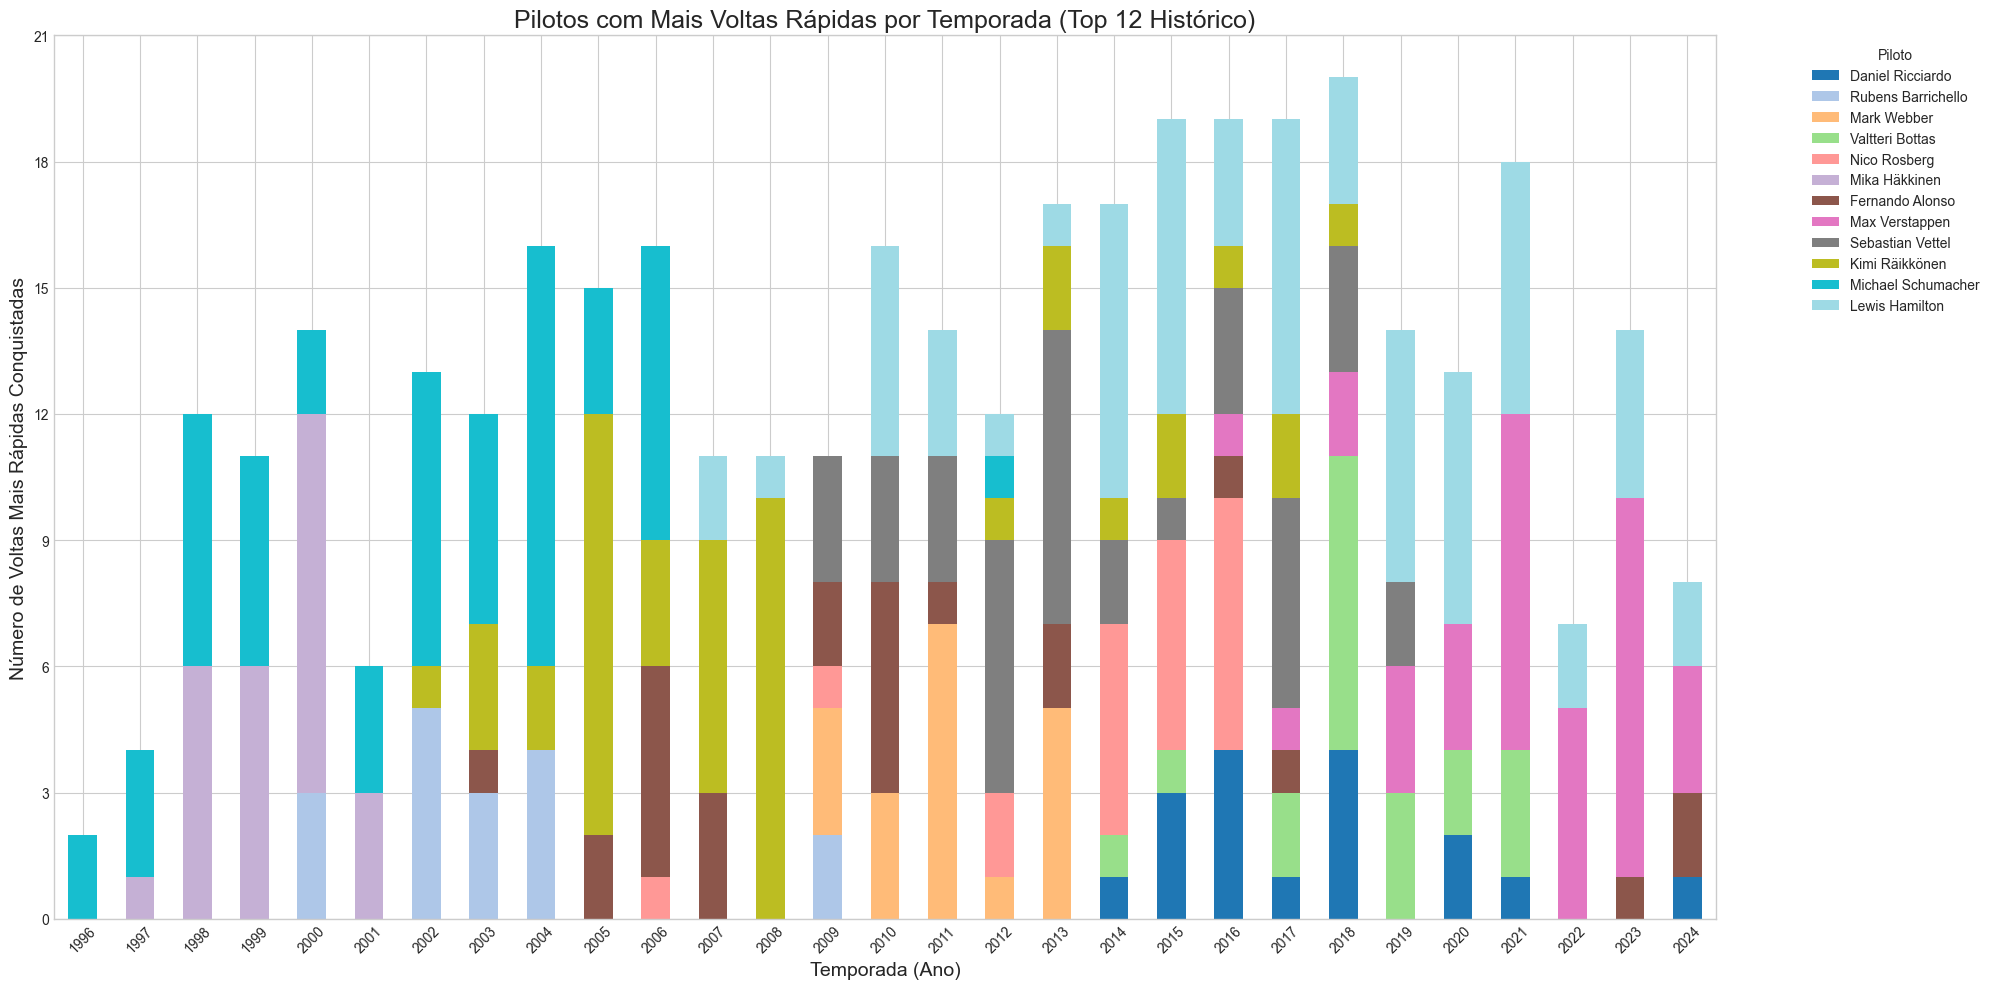

O piloto com mais voltas rápidas na história (presente nos dados) é Lewis Hamilton, com um total de 66 voltas rápidas.


In [113]:
fastest_lap_time_per_race = dataframes['lap_times'].groupBy("raceId").agg(min("milliseconds").alias("fastest_lap_ms"))

fastest_lap_driver_per_race = dataframes['lap_times'].join(fastest_lap_time_per_race, "raceId").filter(col("milliseconds") == col("fastest_lap_ms")).select("raceId", "driverId")

drivers_with_label = dataframes['drivers'].withColumn("driver_name", concat_ws(" ", col("forename"), col("surname")))

fastest_laps_summary = fastest_lap_driver_per_race.join(dataframes['races'], "raceId").join(drivers_with_label, "driverId").select("year", "driver_name")

fastest_lap_counts = fastest_laps_summary.groupBy("year", "driver_name").agg(count("*").alias("fastest_lap_count")).orderBy("year", "fastest_lap_count")

plot_data_stacked = fastest_lap_counts.toPandas()

driver_totals = plot_data_stacked.groupby('driver_name')['fastest_lap_count'].sum()
top_12_names = driver_totals.nlargest(12).index
sorted_top_12_totals = driver_totals[top_12_names].sort_values(ascending=True)
plot_order = sorted_top_12_totals.index.tolist()

plot_data_filtered = plot_data_stacked[plot_data_stacked['driver_name'].isin(plot_order)]

pivot_df = plot_data_filtered.pivot(index='year', columns='driver_name', values='fastest_lap_count').fillna(0)
pivot_df = pivot_df[plot_order]

ax = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(20, 10),
    colormap='tab20'
)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Pilotos com Mais Voltas Rápidas por Temporada (Top 12 Histórico)', fontsize=18)
plt.xlabel('Temporada (Ano)', fontsize=14)
plt.ylabel('Número de Voltas Mais Rápidas Conquistadas', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Piloto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

overall_leader = driver_totals.nlargest(1).index[0]
overall_count = driver_totals.nlargest(1).values[0]

print(f"O piloto com mais voltas rápidas na história (presente nos dados) é {overall_leader}, com um total de {overall_count} voltas rápidas.")

### Consistência vs velocidade de pilotos


- **Objetivo do gráfico:** Relacionar velocidade média das voltas com consistência (baixa variabilidade) dos pilotos mais atuantes.
- **Dados utilizados:** `lap_times` para média e desvio padrão por piloto/corrida e `drivers` para rotular os participantes.
- **Ações principais:** Agrupa por corrida e piloto, calculando média e desvio padrão; descarta casos sem variância; seleciona os 15 pilotos mais presentes; converte valores para segundos; gera gráfico de dispersão e calcula o piloto de menor desvio médio.
- **Saída:** Gráfico `Consistência vs. Velocidade Média por Piloto` e mensagem destacando o piloto mais consistente.
- **Insight esperado:** Distinguir pilotos velozes porém instáveis daqueles que combinam rapidez com regularidade.
- **Possíveis extensões:** Incluir tamanho do marcador proporcional ao número de corridas para contextualizar experiência.


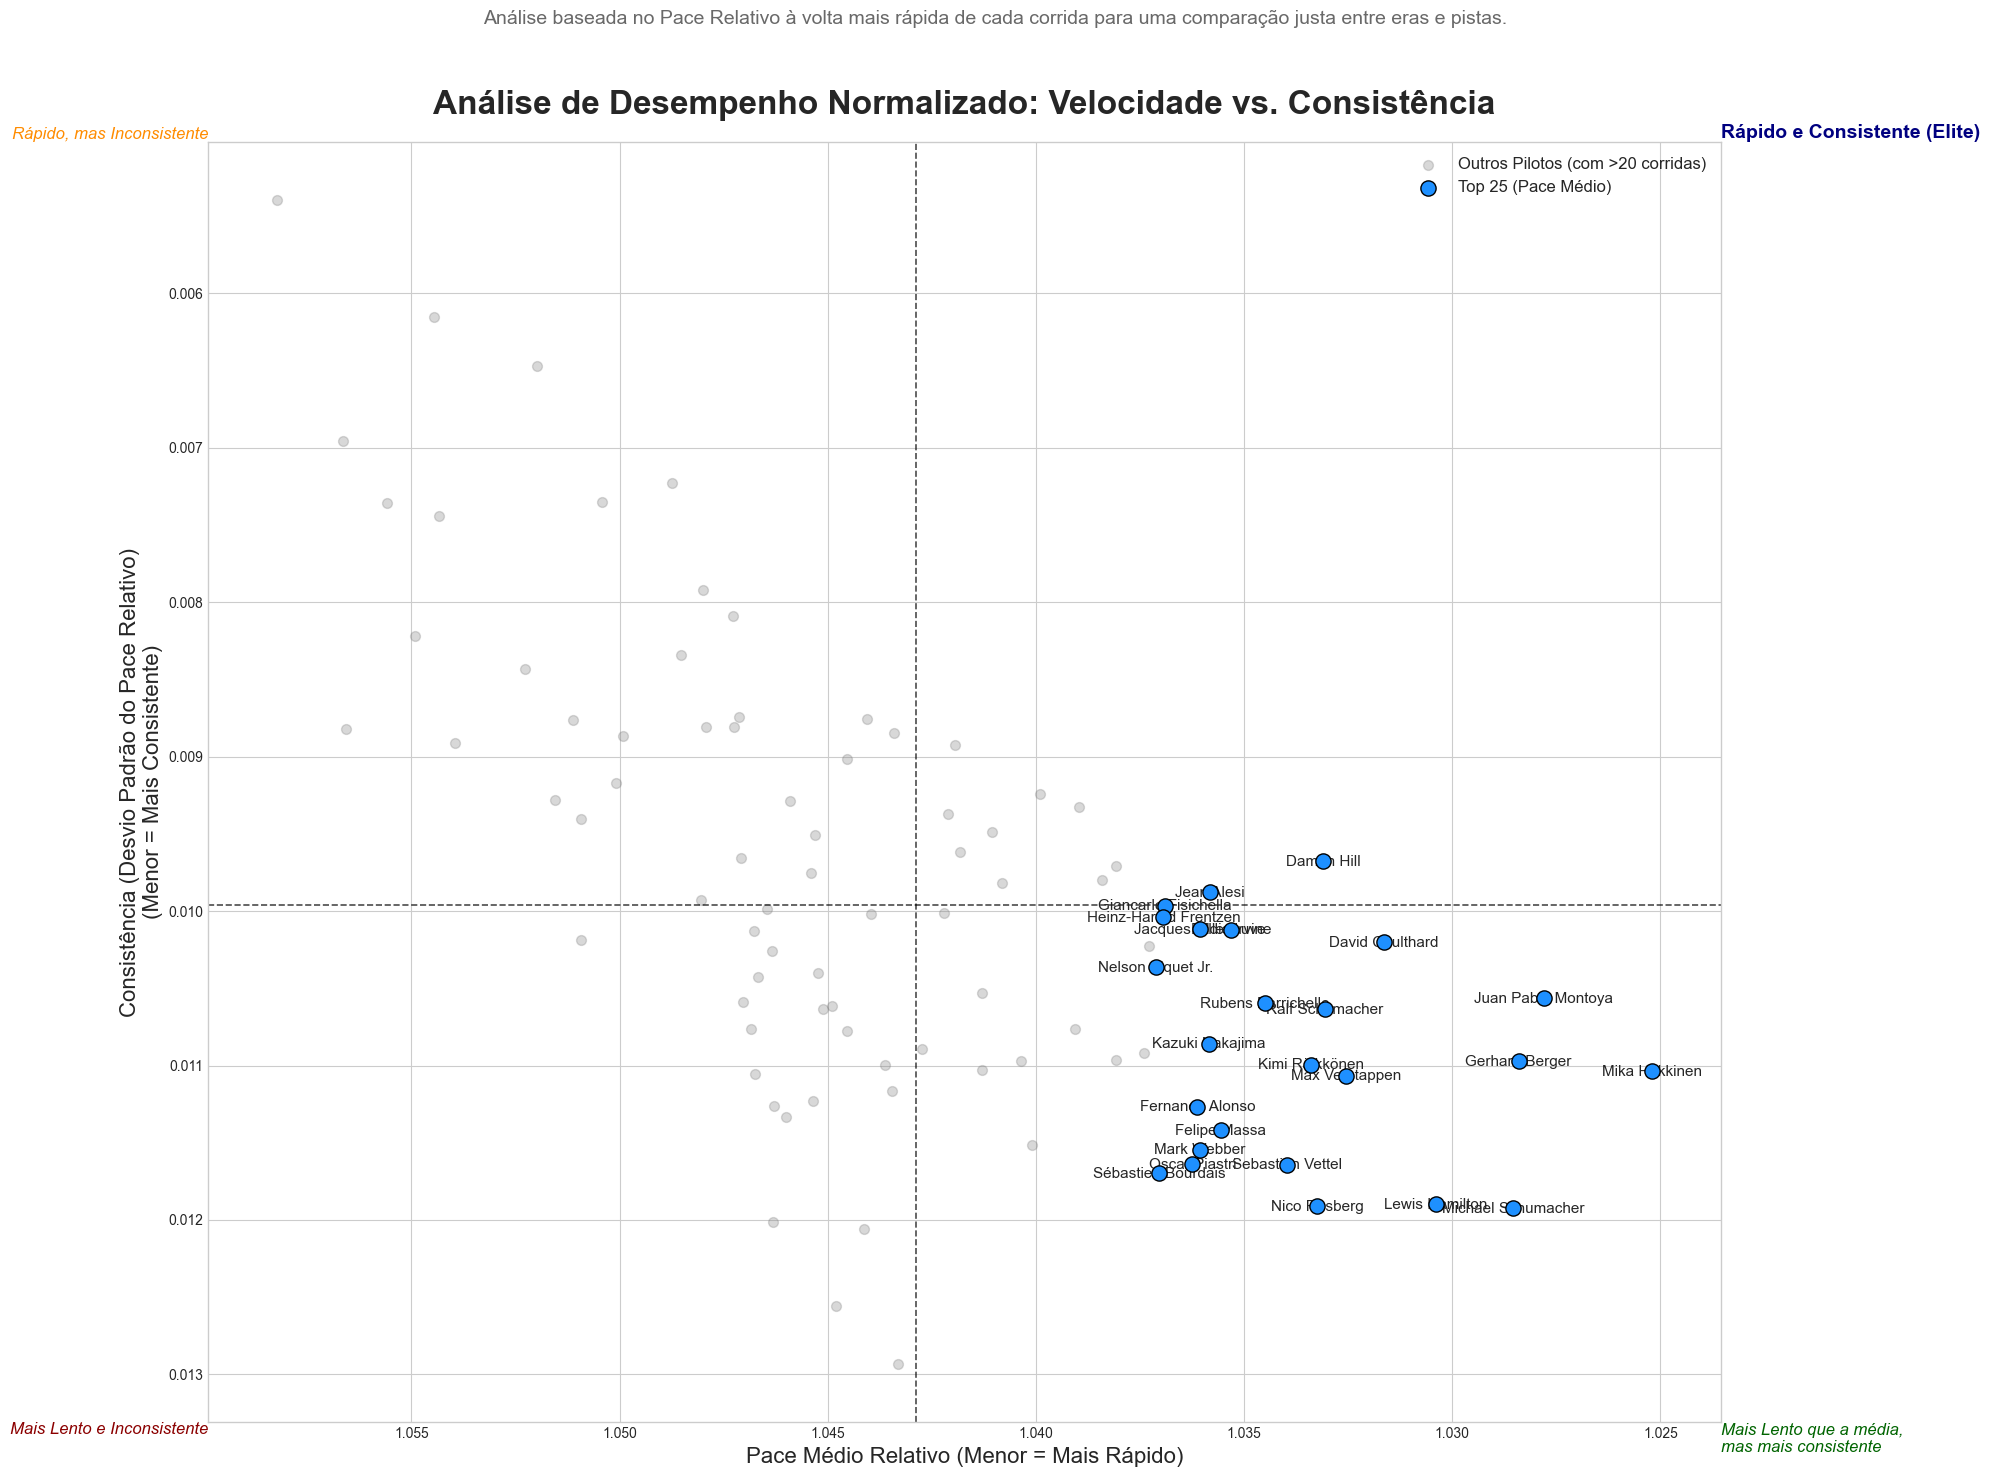

--- Análise Aprofundada dos Resultados Corrigidos ---
Com base em uma amostra de pilotos com pelo menos 20 corridas, a média do pace relativo é 1.0429 e a média da consistência é 0.00996.

Pilotos no 'Quadrante de Elite' (mais rápidos e mais consistentes que a média) entre os 25 melhores analisados:
- Damon Hill
- Jean Alesi


In [114]:
spark.conf.set("spark.sql.shuffle.partitions", 200)

fastest_lap_per_race = dataframes['lap_times'].groupBy('raceId').agg(min('milliseconds').alias('fastest_lap_in_race_ms'))

laps_with_benchmark = dataframes['lap_times'].join(fastest_lap_per_race, 'raceId')

laps_with_benchmark = laps_with_benchmark.withColumn(
    'relative_pace',
    col('milliseconds') / col('fastest_lap_in_race_ms')
).filter(col('relative_pace') <= 1.07)

driver_consistency_per_race_df = laps_with_benchmark.groupBy('raceId', 'driverId').agg(
    avg('relative_pace').alias('avg_relative_pace'),
    stddev('relative_pace').alias('stddev_relative_pace')
).filter(col('stddev_relative_pace').isNotNull())

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
full_consistency_df = driver_consistency_per_race_df.join(drivers_with_label, 'driverId')

driver_overall_stats = full_consistency_df.groupBy('driver_name').agg(
    avg('avg_relative_pace').alias('overall_avg_pace'),
    avg('stddev_relative_pace').alias('overall_consistency_stddev'),
    count('raceId').alias('race_count')
)

plot_data_pd = driver_overall_stats.filter(col('race_count') >= 20).toPandas()

mean_pace = plot_data_pd['overall_avg_pace'].mean()
mean_consistency = plot_data_pd['overall_consistency_stddev'].mean()

chart_data = plot_data_pd.sort_values('overall_avg_pace', ascending=True).head(25)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(20, 16))

ax.scatter(plot_data_pd['overall_avg_pace'], plot_data_pd['overall_consistency_stddev'],
           color='gray', alpha=0.3, s=50, label='Outros Pilotos (com >20 corridas)')

ax.scatter(chart_data['overall_avg_pace'], chart_data['overall_consistency_stddev'],
           color='dodgerblue', s=120, zorder=5, ec='black', label='Top 25 (Pace Médio)')

ax.axvline(mean_pace, color='black', linestyle='--', linewidth=1.2, alpha=0.7)
ax.axhline(mean_consistency, color='black', linestyle='--', linewidth=1.2, alpha=0.7)

for i, row in chart_data.iterrows():
    ax.text(row['overall_avg_pace'], row['overall_consistency_stddev'] + 0.00005,
            row['driver_name'], fontsize=11, ha='center', va='bottom')

ax.set_title('Análise de Desempenho Normalizado: Velocidade vs. Consistência', fontsize=24, weight='bold', pad=20)
ax.set_xlabel('Pace Médio Relativo (Menor = Mais Rápido)', fontsize=16)
ax.set_ylabel('Consistência (Desvio Padrão do Pace Relativo)\n(Menor = Mais Consistente)', fontsize=16)

ax.text(ax.get_xlim()[0], ax.get_ylim()[1], 'Mais Lento que a média,\nmas mais consistente',
        fontsize=12, style='italic', color='darkgreen', ha='left', va='top')
ax.text(ax.get_xlim()[1], ax.get_ylim()[1], 'Mais Lento e Inconsistente',
        fontsize=12, style='italic', color='darkred', ha='right', va='top')
ax.text(ax.get_xlim()[0], ax.get_ylim()[0], 'Rápido e Consistente (Elite)',
        fontsize=14, weight='bold', color='navy', ha='left', va='bottom')
ax.text(ax.get_xlim()[1], ax.get_ylim()[0], 'Rápido, mas Inconsistente',
        fontsize=12, style='italic', color='darkorange', ha='right', va='bottom')

fig.suptitle('Análise baseada no Pace Relativo à volta mais rápida de cada corrida para uma comparação justa entre eras e pistas.',
             y=0.92, fontsize=14, color='dimgray')

ax.invert_yaxis()
ax.invert_xaxis()

ax.legend(fontsize=12, loc='upper right')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

elite_drivers = chart_data[
    (chart_data['overall_avg_pace'] < mean_pace) &
    (chart_data['overall_consistency_stddev'] < mean_consistency)
]
print("--- Análise Aprofundada dos Resultados Corrigidos ---")
print(f"Com base em uma amostra de pilotos com pelo menos 20 corridas, a média do pace relativo é {mean_pace:.4f} e a média da consistência é {mean_consistency:.5f}.")
print("\nPilotos no 'Quadrante de Elite' (mais rápidos e mais consistentes que a média) entre os 25 melhores analisados:")
for driver in elite_drivers['driver_name']:
    print(f"- {driver}")

### Evolução média dentro da corrida


- **Objetivo do gráfico:** Entender como o tempo médio de volta evolui ao longo de uma corrida típica.
- **Dados utilizados:** `lap_times` agregados por número de volta em toda a história disponível.
- **Ações principais:** Calcula a média por volta, converte para segundos, filtra até a volta 70, aplica média móvel de 4 voltas e plota duas séries (original e suavizada).
- **Saída:** Gráfico `Evolução do Tempo Médio de Volta Durante as Corridas` com série original e média móvel.
- **Insight esperado:** Detectar fases onde os carros tendem a acelerar ou desacelerar, influenciadas por combustível, pneus ou safety cars.
- **Sugestão analítica:** Comparar segmentos de voltas (ex.: 1-10, 11-20) para corroborar hipóteses sobre estratégias de pit stop.


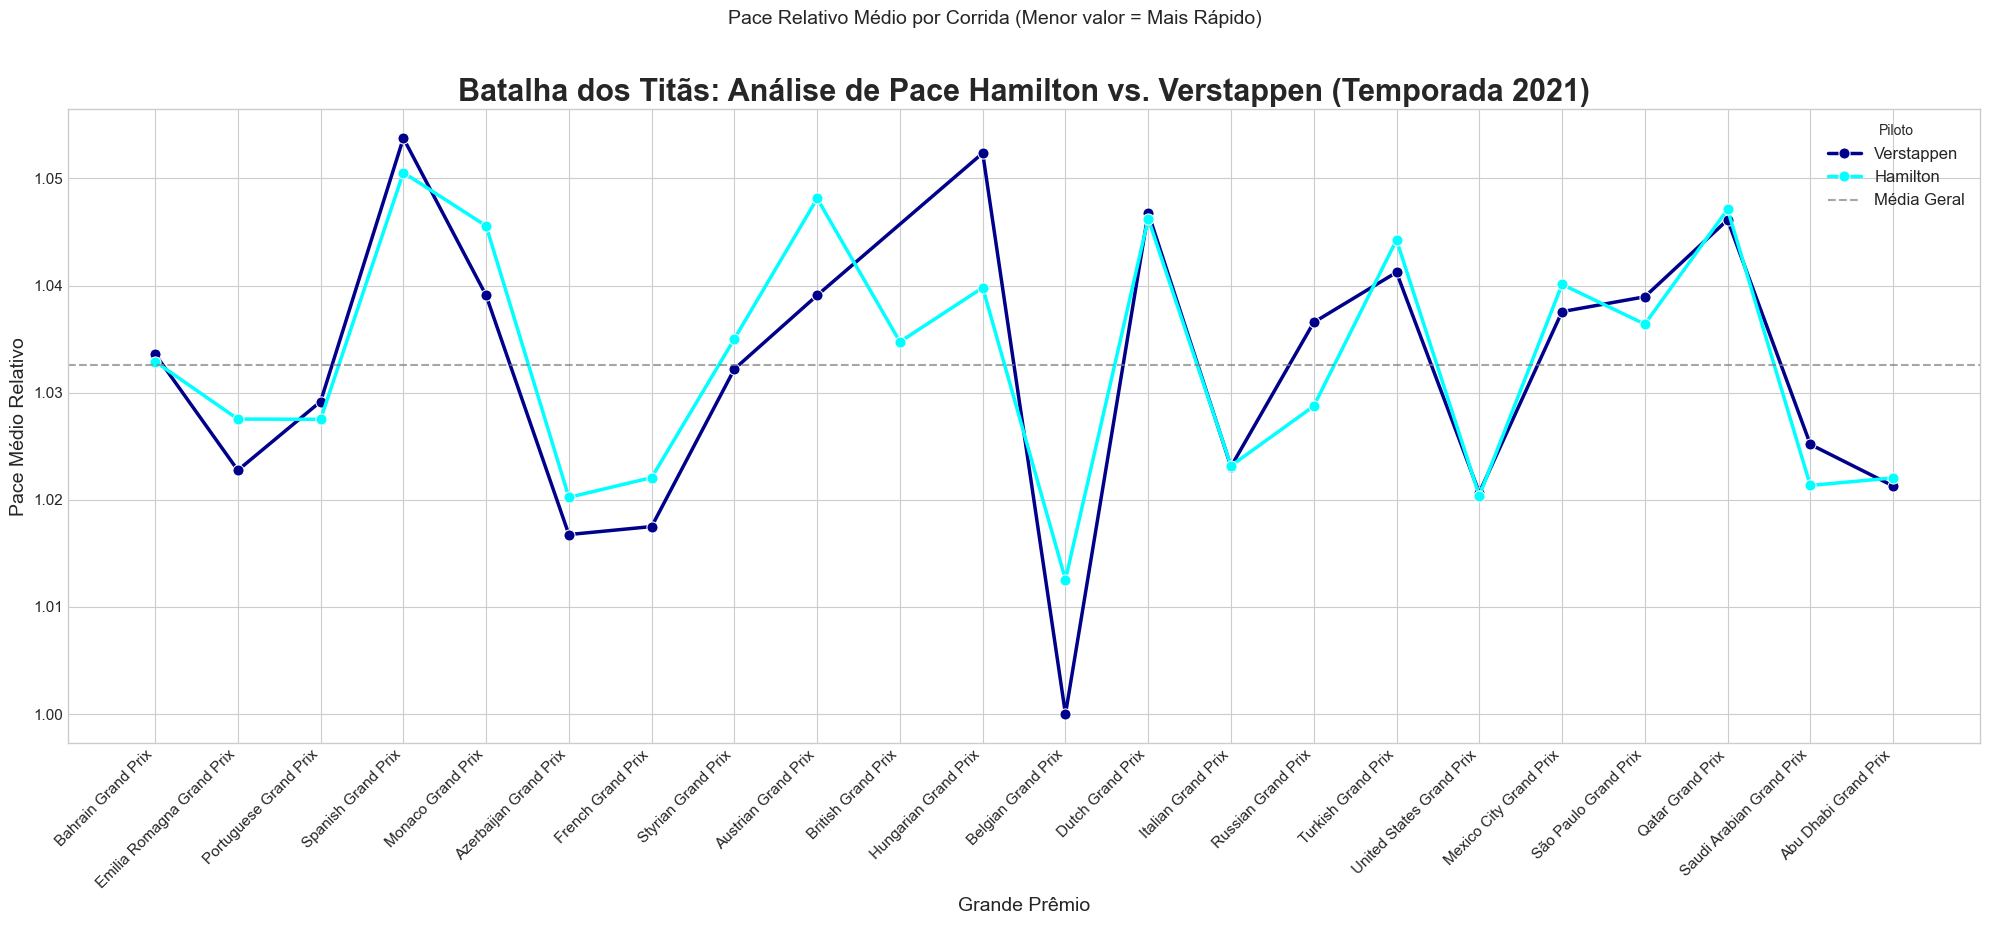

--- Análise de Desempenho: Temporada 2021 ---
Corridas em que Verstappen teve um pace médio mais rápido: 12
Corridas em que Hamilton teve um pace médio mais rápido: 9
--------------------------------------------------
Pace Relativo Médio de Verstappen na temporada: 1.03208
Pace Relativo Médio de Hamilton na temporada:   1.03302

No geral, Max Verstappen teve um pace médio ligeiramente superior ao longo da temporada 2021.


In [115]:
target_season = 2021
driver1_surname = "Verstappen"
driver2_surname = "Hamilton"

drivers_df = dataframes['drivers'].filter(
    (col('surname') == driver1_surname) | (col('surname') == driver2_surname)
).select('driverId', 'surname')

races_2021_df = dataframes['races'].filter(col('year') == target_season)

lap_times_2021_df = dataframes['lap_times'].join(races_2021_df.select('raceId'), 'raceId')
fastest_lap_per_race_2021 = lap_times_2021_df.groupBy('raceId').agg(min('milliseconds').alias('fastest_lap_in_race_ms'))

driver_laps_2021 = lap_times_2021_df.join(drivers_df, 'driverId') \
                                   .join(fastest_lap_per_race_2021, 'raceId')

driver_laps_2021 = driver_laps_2021.withColumn(
    'relative_pace',
    col('milliseconds') / col('fastest_lap_in_race_ms')
).filter(col('relative_pace') <= 1.07)

avg_pace_per_race = driver_laps_2021.groupBy('raceId', 'driverId', 'surname') \
                                     .agg(avg('relative_pace').alias('avg_relative_pace'))

final_df = avg_pace_per_race.join(races_2021_df, 'raceId') \
                             .select('round', 'name', 'surname', 'avg_relative_pace') \
                             .orderBy('round')

plot_data_comparison = final_df.toPandas()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(20, 10))

ax = sns.lineplot(
    data=plot_data_comparison,
    x='name',
    y='avg_relative_pace',
    hue='surname',
    palette={'Verstappen': 'darkblue', 'Hamilton': 'cyan'},
    marker='o',
    markersize=8,
    linewidth=2.5
)

plt.title(f'Batalha dos Titãs: Análise de Pace Hamilton vs. Verstappen (Temporada {target_season})', fontsize=22, weight='bold')
plt.suptitle('Pace Relativo Médio por Corrida (Menor valor = Mais Rápido)', fontsize=14, y=0.92)
plt.xlabel('Grande Prêmio', fontsize=14)
plt.ylabel('Pace Médio Relativo', fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

ax.axhline(plot_data_comparison['avg_relative_pace'].mean(), ls='--', color='gray', alpha=0.7, label='Média Geral de Pace')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Verstappen', 'Hamilton', 'Média Geral'], title='Piloto', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

verstappen_pace = plot_data_comparison[plot_data_comparison['surname'] == 'Verstappen'].reset_index()
hamilton_pace = plot_data_comparison[plot_data_comparison['surname'] == 'Hamilton'].reset_index()

compare_df = pd.merge(verstappen_pace, hamilton_pace, on='round', suffixes=('_ver', '_ham'))
compare_df['faster_driver'] = compare_df.apply(lambda row: 'Verstappen' if row['avg_relative_pace_ver'] < row['avg_relative_pace_ham'] else 'Hamilton', axis=1)

verstappen_wins = (compare_df['faster_driver'] == 'Verstappen').sum()
hamilton_wins = (compare_df['faster_driver'] == 'Hamilton').sum()

verstappen_season_avg = verstappen_pace['avg_relative_pace'].mean()
hamilton_season_avg = hamilton_pace['avg_relative_pace'].mean()

print("--- Análise de Desempenho: Temporada 2021 ---")
print(f"Corridas em que Verstappen teve um pace médio mais rápido: {verstappen_wins}")
print(f"Corridas em que Hamilton teve um pace médio mais rápido: {hamilton_wins}")
print("-" * 50)
print(f"Pace Relativo Médio de Verstappen na temporada: {verstappen_season_avg:.5f}")
print(f"Pace Relativo Médio de Hamilton na temporada:   {hamilton_season_avg:.5f}")

if verstappen_season_avg < hamilton_season_avg:
    print("\nNo geral, Max Verstappen teve um pace médio ligeiramente superior ao longo da temporada 2021.")
else:
    print("\nNo geral, Lewis Hamilton teve um pace médio ligeiramente superior ao longo da temporada 2021.")


### Melhor volta individual de cada piloto


- **Objetivo do gráfico:** Listar os pilotos que registraram as voltas mais rápidas absolutas na base.
- **Dados utilizados:** `lap_times` para o tempo mínimo por piloto e `drivers` para montar o nome completo.
- **Ações principais:** Calcula o menor tempo por `driverId`, junta com nomes, converte para segundos, ordena, transforma em Pandas e plota o Top 25 em barras horizontais.
- **Saída:** Gráfico `Melhor Volta Pessoal de Cada Piloto (Top 25)` e impressão do recordista geral.
- **Insight esperado:** Fornecer referência de pico de performance individual, útil para comparar talentos ou eras.
- **Nota contextual:** Voltas rápidas podem refletir compostos de pneus, regimes de combustível e regulamentações específicas de cada ano.


C:\Users\julii\AppData\Local\Temp\ipykernel_2392\2758785992.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


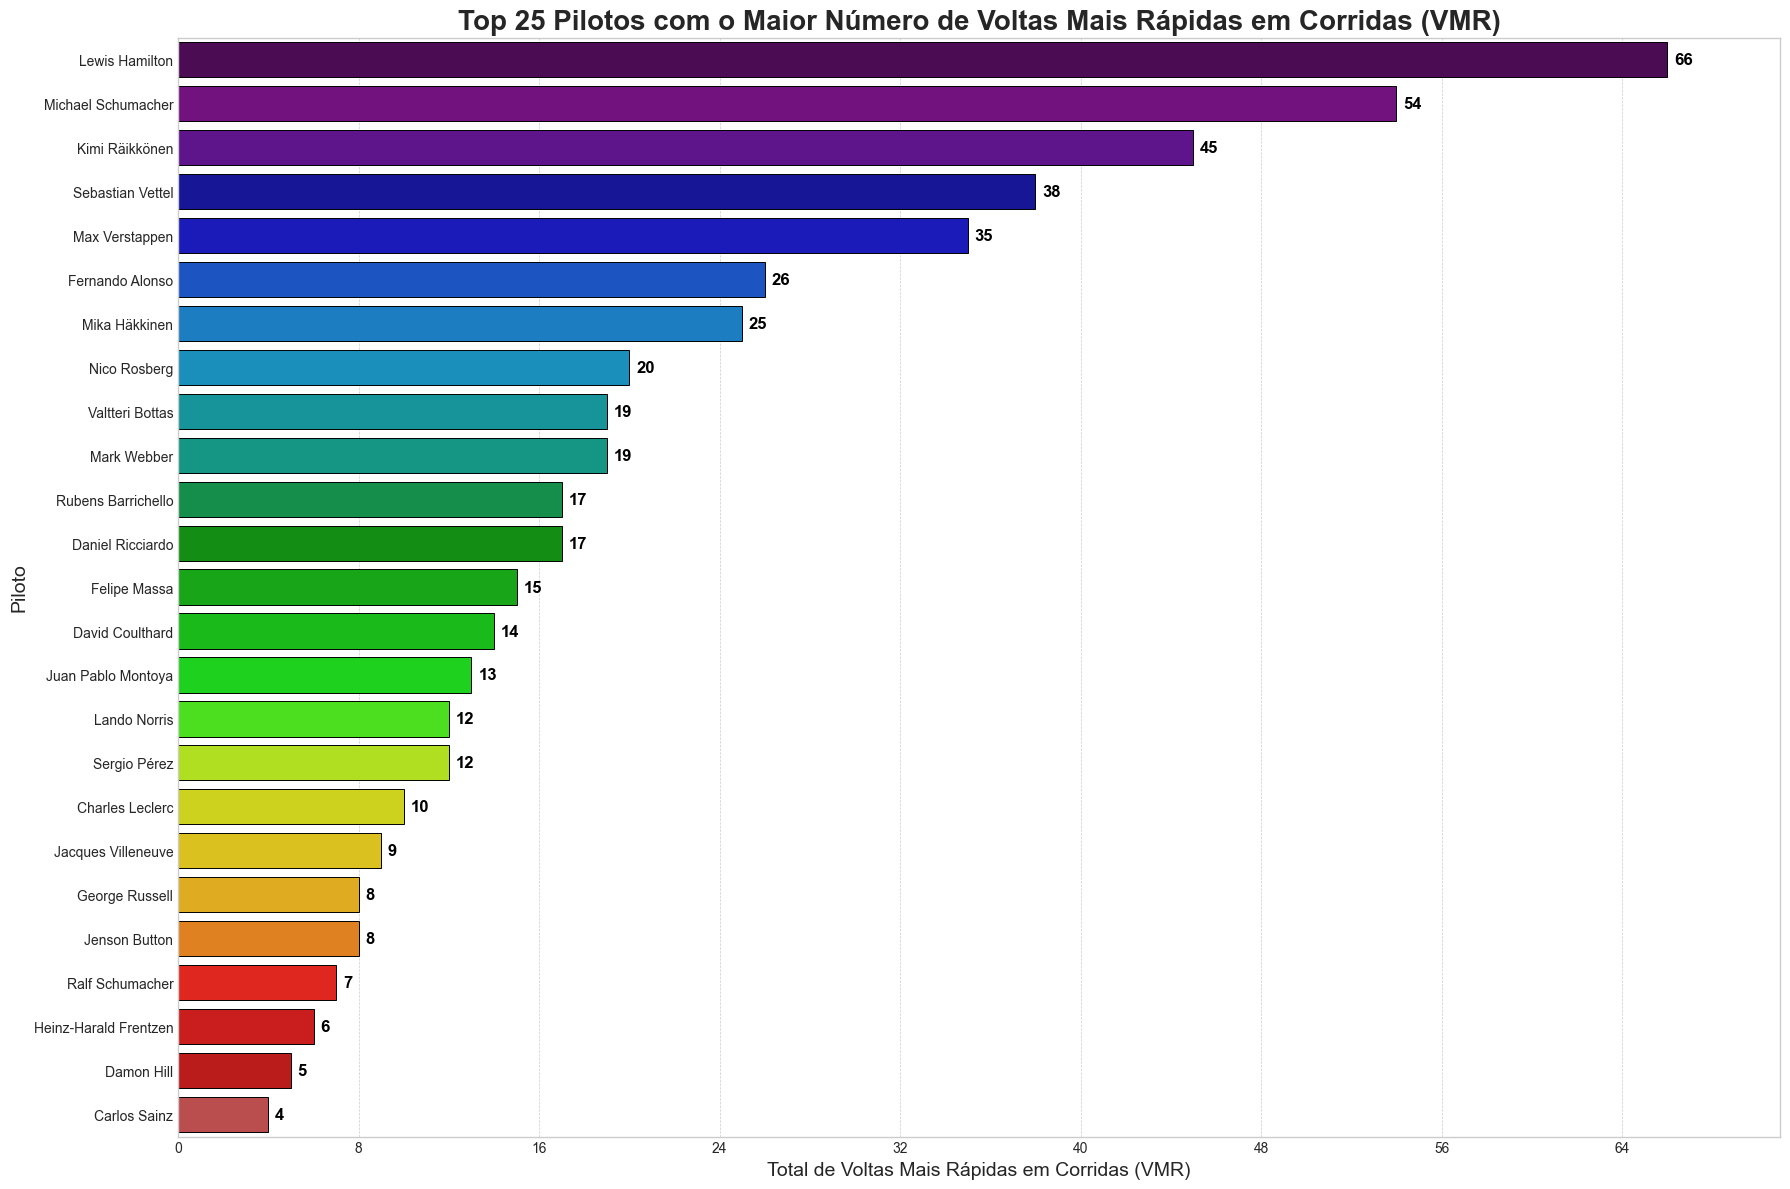

O piloto com o maior número de voltas mais rápidas em corridas (VMR) na base de dados é Lewis Hamilton com um total de 66 VMR.


In [116]:

window_spec_race = Window.partitionBy('raceId').orderBy('milliseconds')
fastest_lap_in_each_race = dataframes['lap_times'].withColumn('rank', rank().over(window_spec_race)) \
                                                  .filter(col('rank') == 1).drop('rank')

fastest_lap_counts = fastest_lap_in_each_race.groupBy('driverId').agg(count('*').alias('fastest_race_lap_count'))

drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
final_plot_data_spark = fastest_lap_counts.join(drivers_with_label, 'driverId') \
                                          .orderBy(col('fastest_race_lap_count').desc())

plot_data_pd = final_plot_data_spark.select('driver_name', 'fastest_race_lap_count').toPandas()

top_n = 25
chart_data = plot_data_pd.head(top_n)

plt.figure(figsize=(18, 12))

colors = sns.color_palette("nipy_spectral", n_colors=len(chart_data))
color_map = {driver: color for driver, color in zip(chart_data['driver_name'], colors)}

ax = sns.barplot(
    data=chart_data,
    x='fastest_race_lap_count',
    y='driver_name',
    orient='h',
    palette=color_map,
    edgecolor='black',
    linewidth=0.7
)

for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 0.3,
        p.get_y() + p.get_height() / 2,
        f'{int(width)}',
        ha='left',
        va='center',
        fontsize=12,
        color='black',
        weight='bold'
    )

plt.title(f'Top {top_n} Pilotos com o Maior Número de Voltas Mais Rápidas em Corridas (VMR)', fontsize=20, weight='bold')
plt.xlabel('Total de Voltas Mais Rápidas em Corridas (VMR)', fontsize=14)
plt.ylabel('Piloto', fontsize=14)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlim(right=chart_data['fastest_race_lap_count'].max() + 5)

plt.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')
plt.tight_layout()
plt.show()

most_fastest_laps_driver = plot_data_pd.iloc[0]
print(f"O piloto com o maior número de voltas mais rápidas em corridas (VMR) na base de dados é {most_fastest_laps_driver['driver_name']} com um total de {most_fastest_laps_driver['fastest_race_lap_count']} VMR.")

### Desempenho médio por construtor


- **Objetivo do gráfico:** Avaliar quais construtores registram menor tempo médio de volta.
- **Dados utilizados:** `lap_times` combinados com `results` (para mapear construtor) e `constructors` (nome da equipe).
- **Ações principais:** Cria o mapa corrida/piloto/construtor, associa aos tempos de volta, calcula a média por equipe, converte para segundos, ordena e plota o Top 25.
- **Saída:** Gráfico `Tempo Médio de Volta por Construtor (Top 25)` e mensagem apontando a equipe mais veloz em média.
- **Insight esperado:** Compreender a dominância técnica das equipes em ritmo de corrida.
- **Ponto de atenção:** Diferenças na quantidade de temporadas disputadas podem distorcer a média; considerar normalização futura.


C:\Users\julii\AppData\Local\Temp\ipykernel_2392\2483809143.py:94: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_yticklabels)


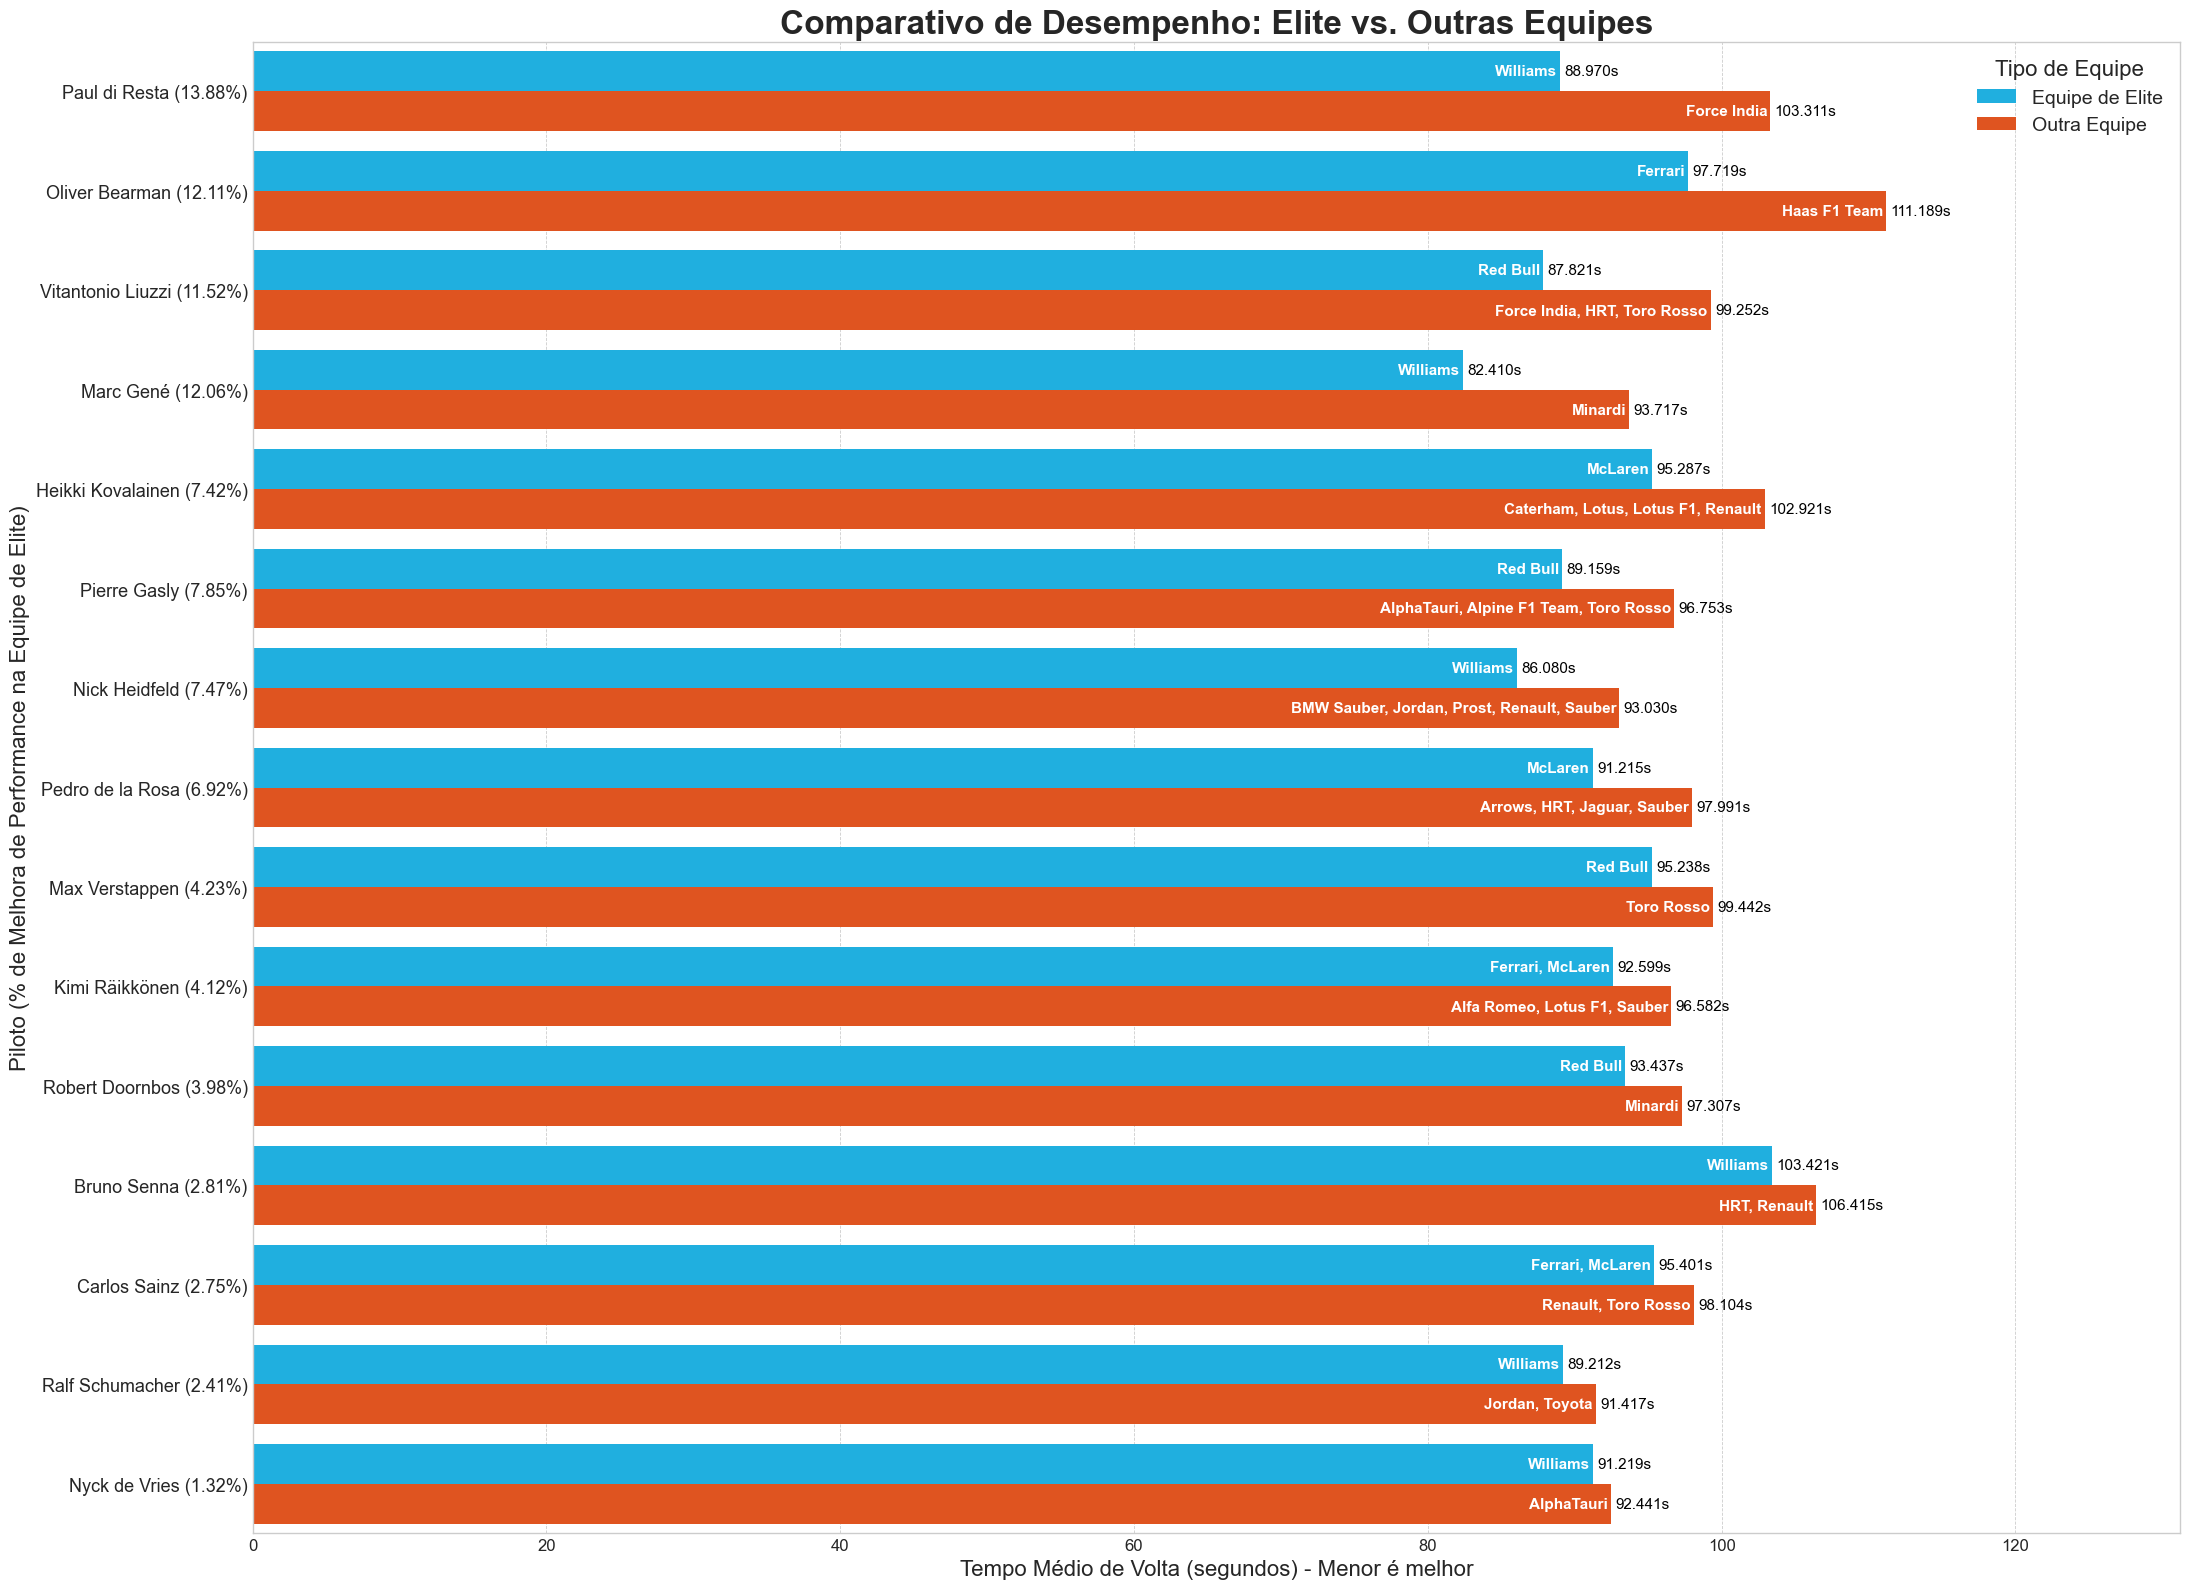

In [117]:
top_team_names = ["Ferrari", "McLaren", "Red Bull", "Mercedes", "Williams"]
top_teams_df = dataframes['constructors'].filter(F.col('name').isin(top_team_names))
top_team_ids = [row.constructorId for row in top_teams_df.select('constructorId').collect()]

results_filtered = dataframes['results'].select('raceId', 'driverId', 'constructorId').distinct()
laps_with_constructors = dataframes['lap_times'].join(results_filtered, on=['raceId', 'driverId'], how='inner')
laps_with_names = laps_with_constructors.join(dataframes['constructors'].select('constructorId', 'name'), 'constructorId')

laps_with_category = laps_with_names.withColumn(
    "team_category",
    F.when(F.col("constructorId").isin(top_team_ids), "Equipe de Elite").otherwise("Outra Equipe")
)

driver_perf_by_category = laps_with_category.groupBy('driverId', 'team_category') \
    .agg(
        (F.avg('milliseconds') / 1000).alias('avg_lap_s'),
        F.collect_set('name').alias('teams_list')
    )

drivers_with_names = dataframes['drivers'].withColumn('driver_name', F.concat_ws(' ', F.col('forename'), F.col('surname')))
driver_perf_with_names = driver_perf_by_category.join(drivers_with_names, 'driverId')

driver_category_counts = driver_perf_with_names.groupBy('driverId').count()
drivers_in_both_ids = driver_category_counts.filter(F.col('count') == 2).select('driverId')
final_df = driver_perf_with_names.join(drivers_in_both_ids, 'driverId', 'inner')

pivot_df = final_df.groupBy('driver_name').pivot('team_category').agg(F.first('avg_lap_s'))
gain_df = pivot_df.withColumn('gain', F.col('Outra Equipe') - F.col('Equipe de Elite')) \
                  .withColumn('percentage_gain', (F.col('gain') / F.col('Outra Equipe')) * 100) \
                  .orderBy(F.col('gain').desc())

plot_data_pd = final_df.join(gain_df.select('driver_name', 'gain', 'percentage_gain'), 'driver_name', 'inner') \
    .orderBy(F.col('gain').desc(), F.col('team_category')) \
    .toPandas()

plot_data_pd['teams_str'] = plot_data_pd['teams_list'].apply(lambda x: ', '.join(sorted(x)))

top_drivers_order = plot_data_pd['driver_name'].unique()[:15]
chart_data = plot_data_pd[plot_data_pd['driver_name'].isin(top_drivers_order)]
hue_order = ['Equipe de Elite', 'Outra Equipe']

percentage_map = chart_data[['driver_name', 'percentage_gain']].drop_duplicates().set_index('driver_name')['percentage_gain']
new_yticklabels = [f"{driver} ({percentage_map[driver]:.2f}%)" for driver in top_drivers_order]

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(22, 16))

sns.barplot(
    data=chart_data,
    y='driver_name',
    x='avg_lap_s',
    hue='team_category',
    orient='h',
    palette={'Equipe de Elite': '#00BFFF', 'Outra Equipe': '#FF4500'},
    ax=ax,
    order=top_drivers_order,
    hue_order=hue_order
)

for category_index, container in enumerate(ax.containers):
    category = hue_order[category_index]
    for driver_index, p in enumerate(container):
        driver_name = top_drivers_order[driver_index]
        row_data = chart_data[
            (chart_data['driver_name'] == driver_name) & 
            (chart_data['team_category'] == category)
        ]
        
        if not row_data.empty:
            teams_string = row_data.iloc[0]['teams_str']
            width = p.get_width()

            ax.text(width + 0.3,
                    p.get_y() + p.get_height() / 2,
                    f'{width:.3f}s',
                    ha='left',
                    va='center',
                    fontsize=11,
                    color='black')

            if width > 5:
                ax.text(width - 0.2,
                        p.get_y() + p.get_height() / 2,
                        teams_string,
                        ha='right',
                        va='center',
                        color='white',
                        fontsize=11,
                        weight='bold')

ax.set_title('Comparativo de Desempenho: Elite vs. Outras Equipes', fontsize=24, weight='bold')
ax.set_xlabel('Tempo Médio de Volta (segundos) - Menor é melhor', fontsize=16)
ax.set_ylabel('Piloto (% de Melhora de Performance na Equipe de Elite)', fontsize=16)
ax.set_yticklabels(new_yticklabels)
ax.tick_params(axis='y', labelsize=13)
ax.tick_params(axis='x', labelsize=12)
ax.set_xlim(right=chart_data['avg_lap_s'].max() * 1.18)
ax.legend(title='Tipo de Equipe', fontsize=14, title_fontsize=16)
ax.grid(True, which='major', linestyle='--', linewidth=0.6, axis='x')

plt.tight_layout()
plt.show()

### Posição média de pilotos experientes


- **Objetivo do gráfico:** Comparar a posição média de chegada entre pilotos com grande volume de voltas acumuladas.
- **Dados utilizados:** `lap_times` para posições e contagem de voltas, `drivers` para rotular.
- **Ações principais:** Filtra pilotos com mais de 2000 voltas, calcula a posição média, associa nomes, ordena, converte para Pandas e plota o Top 25.
- **Saída:** Gráfico `Posição Média em Corrida por Piloto (com mais de 2000 voltas)` e mensagem com o piloto de melhor média.
- **Insight esperado:** Destacar competidores que se mantêm regularmente nas primeiras posições quando têm amostra representativa.
- **Consideração adicional:** Cruzar com equipes ou períodos históricos para contextualizar a média encontrada.


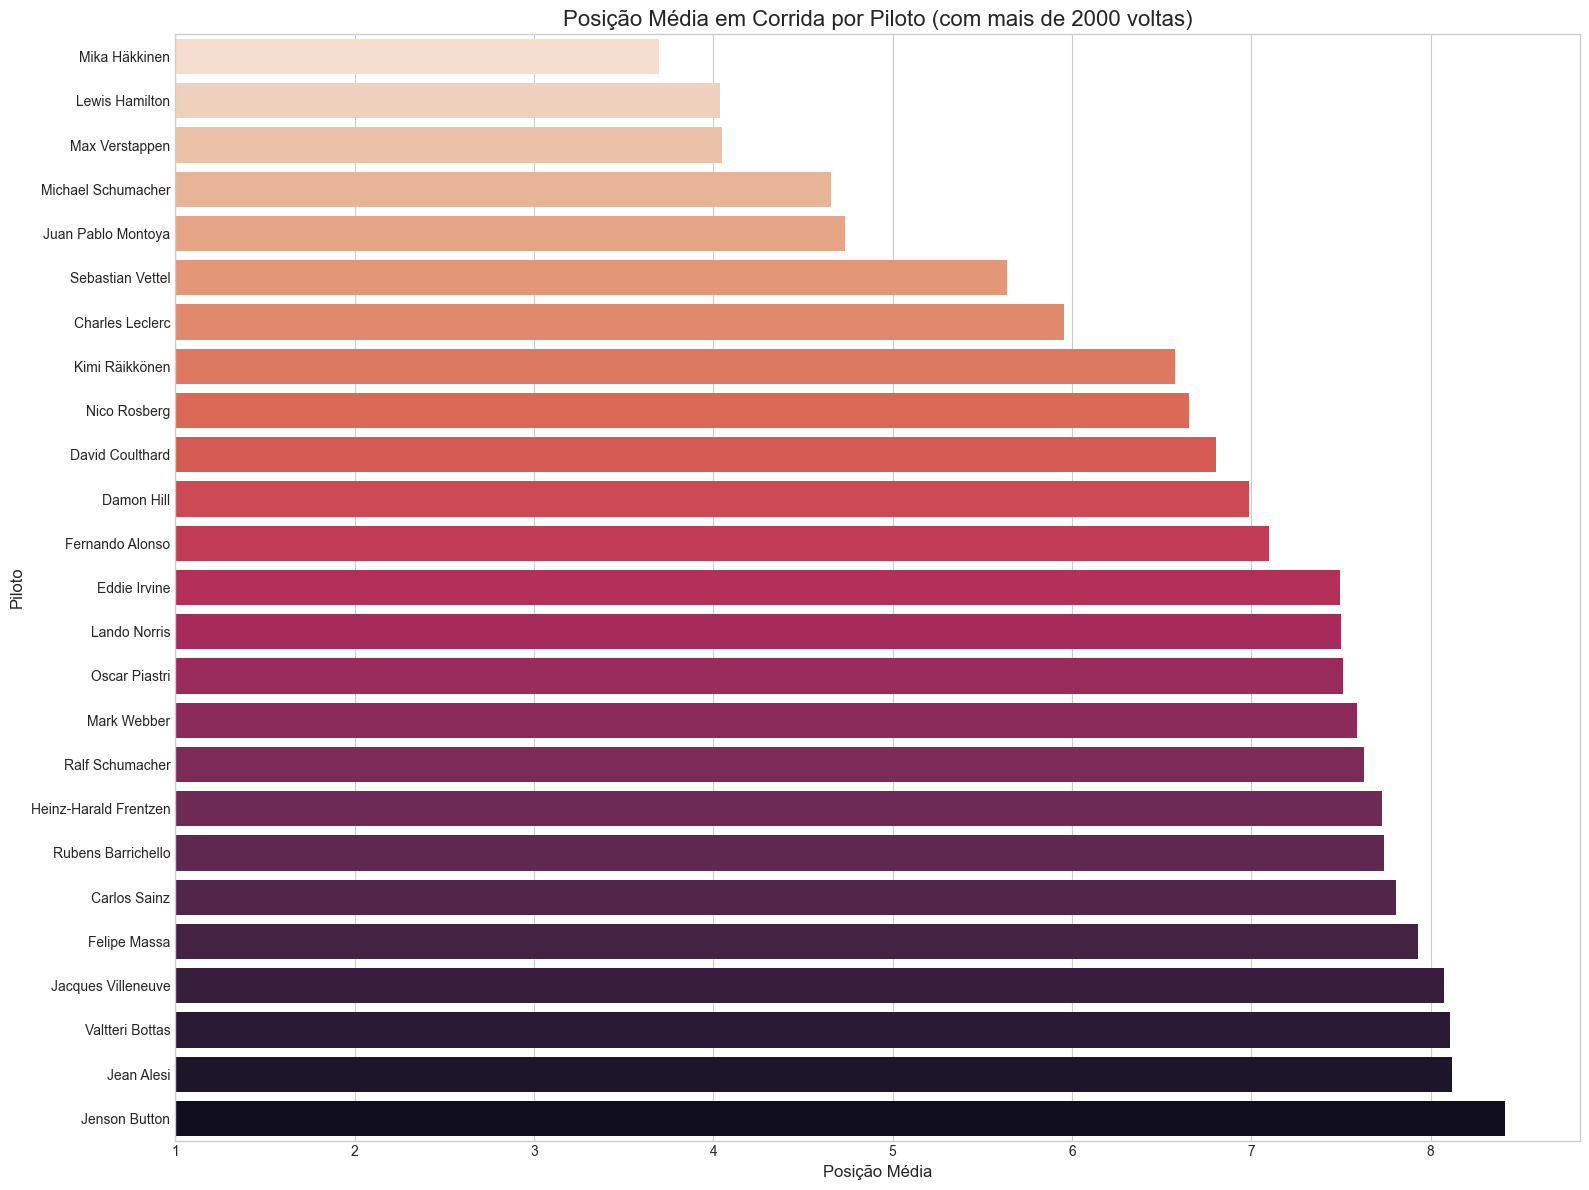

O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: Mika Häkkinen com uma posição média de 3.70.


In [118]:
from pyspark.sql.functions import avg, col, count, concat_ws
experienced_drivers = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps')).filter(col('total_laps') > 2000).select('driverId')
avg_position_per_driver = dataframes['lap_times'].join(experienced_drivers, 'driverId', 'inner').groupBy('driverId').agg(avg('position').alias('avg_position'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_avg_position_details = avg_position_per_driver.join(drivers_with_label, 'driverId').orderBy('avg_position')
plot_data_11 = driver_avg_position_details.select('driver_name', 'avg_position').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_11.head(25), x='avg_position', y='driver_name', orient='h', palette='rocket_r', hue='driver_name', legend=False)
plt.xlim(left=1)
plt.title('Posição Média em Corrida por Piloto (com mais de 2000 voltas)', fontsize=16)
plt.xlabel('Posição Média', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
most_stable_driver = plot_data_11.iloc[0]
print(f"O piloto com a melhor posição média em corrida, indicando maior estabilidade na liderança, é: {most_stable_driver['driver_name']} com uma posição média de {most_stable_driver['avg_position']:.2f}.")


### Total de voltas por piloto


- **Objetivo do gráfico:** Medir a quilometragem total de cada piloto em número de voltas completadas.
- **Dados utilizados:** `lap_times` para contagem de voltas e `drivers` para nomes.
- **Ações principais:** Agrupa por piloto, conta o total de voltas, associa nomes, ordena, converte para Pandas e plota o Top 25.
- **Saída:** Gráfico `Total de Voltas Completadas por Piloto (Top 25)` e texto indicando o piloto mais longevo.
- **Insight esperado:** Evidenciar resistência e permanência na categoria, base para analisar carreiras longas.
- **Complemento sugerido:** Relacionar com número de corridas disputadas ou temporadas para obter métricas proporcionais.


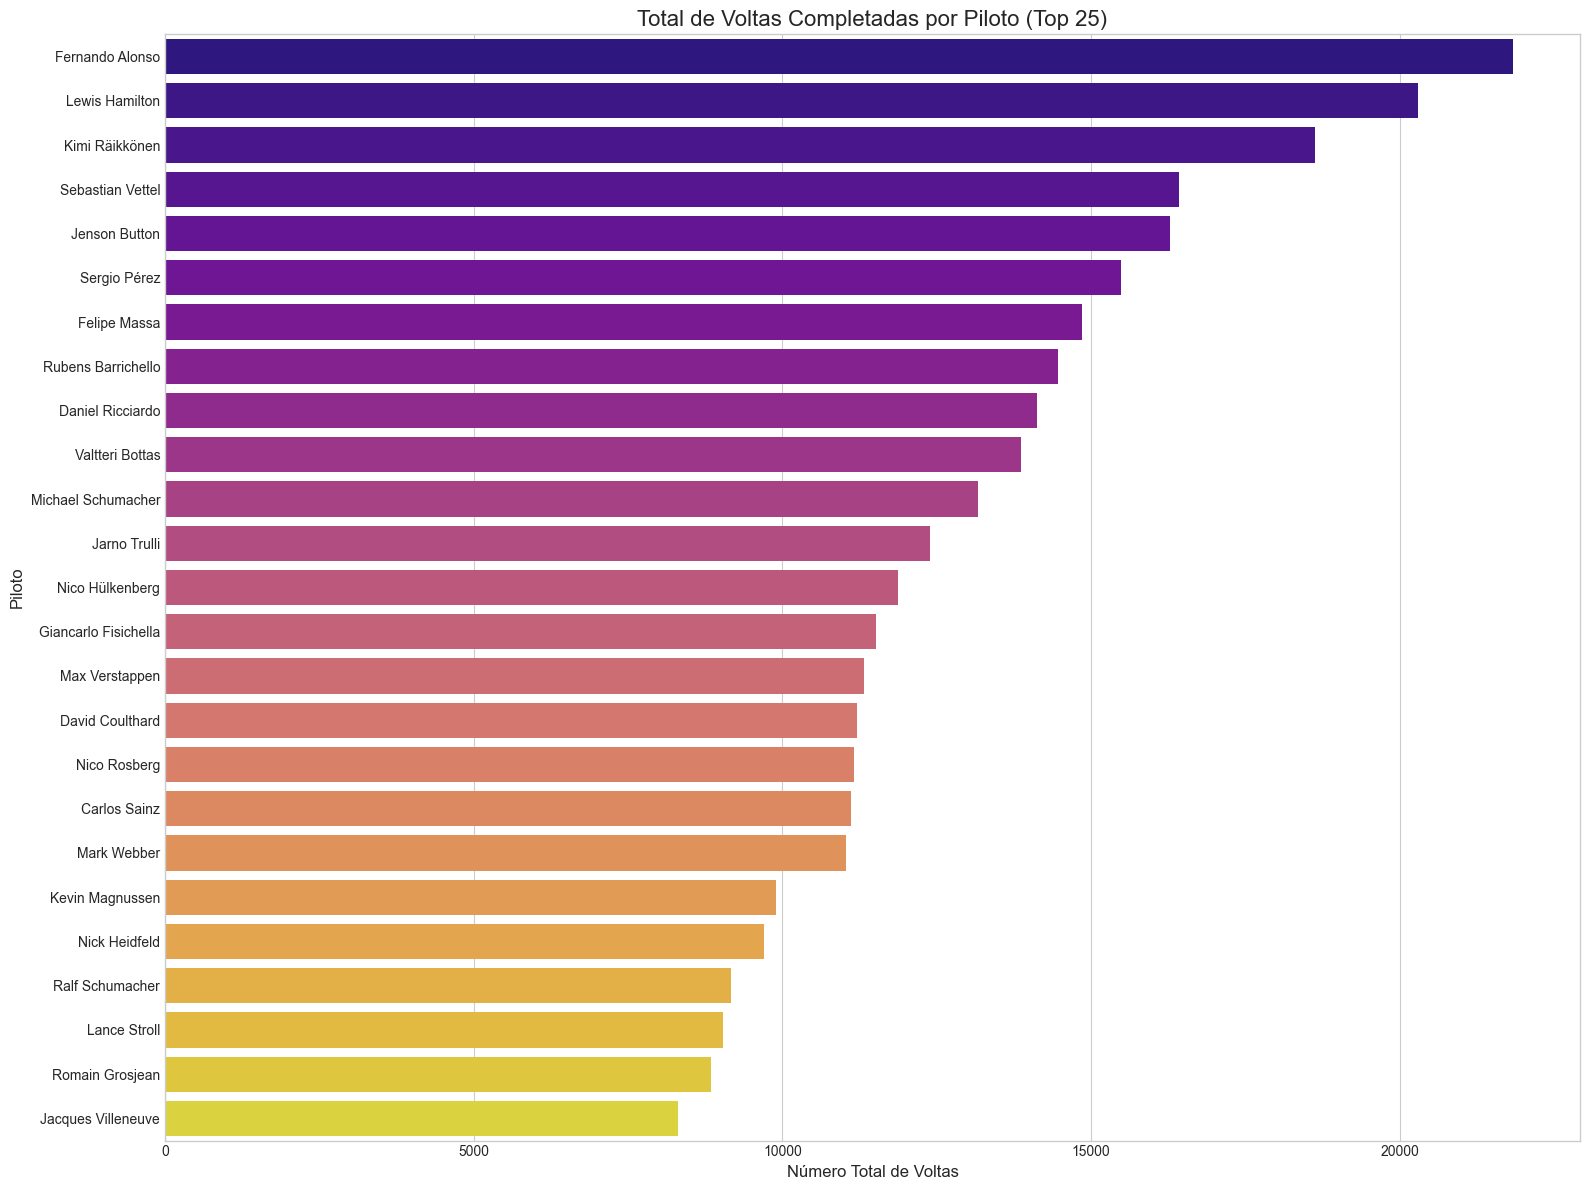

O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: Fernando Alonso com um total de 21829 voltas.


In [119]:
from pyspark.sql.functions import count, col, concat_ws
total_laps_per_driver = dataframes['lap_times'].groupBy('driverId').agg(count('*').alias('total_laps'))
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
driver_laps_details = total_laps_per_driver.join(drivers_with_label, 'driverId').orderBy(col('total_laps').desc())
plot_data_12 = driver_laps_details.select('driver_name', 'total_laps').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_12.head(25), x='total_laps', y='driver_name', orient='h', palette='plasma', hue='driver_name', legend=False)
plt.title('Total de Voltas Completadas por Piloto (Top 25)', fontsize=16)
plt.xlabel('Número Total de Voltas', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
most_laps_driver = plot_data_12.iloc[0]
print(f"O piloto que completou mais voltas, demonstrando grande longevidade e resistência, é: {most_laps_driver['driver_name']} com um total de {most_laps_driver['total_laps']} voltas.")


### Total de voltas por piloto (variação com salvamento)


### Dispersão de performance por circuito


- **Objetivo do gráfico:** Avaliar o quão disputado ou dominado é cada circuito medindo a dispersão dos tempos médios dos pilotos.
- **Dados utilizados:** `lap_times` combinados com `races` e `circuits` para ligar pilotos a circuitos.
- **Ações principais:** Calcula o tempo médio de cada piloto por circuito, agrega o desvio padrão por pista, converte para segundos, ordena e plota o ranking completo.
- **Saída:** Gráfico `Dispersão de Desempenho (Desvio Padrão) Entre Pilotos por Circuito` e mensagens apontando circuitos extremos.
- **Insight esperado:** Diferenciar pistas dominadas por poucos pilotos (desvio alto) de pistas equilibradas (desvio baixo).
- **Follow-up sugerido:** Integrar estatísticas de ultrapassagens ou clima para justificar a dispersão observada.


In [ ]:
from pyspark.sql.functions import avg, stddev, col
laps_with_races = dataframes['lap_times'].join(dataframes['races'], 'raceId')
avg_time_per_driver_circuit = laps_with_races.groupBy('circuitId', 'driverId').agg(avg('milliseconds').alias('avg_driver_circuit_ms'))
performance_spread_per_circuit = avg_time_per_driver_circuit.groupBy('circuitId').agg(stddev('avg_driver_circuit_ms').alias('spread_ms'))
spread_details = performance_spread_per_circuit.join(dataframes['circuits'], 'circuitId').withColumn('spread_s', col('spread_ms') / 1000).orderBy(col('spread_s').desc())
plot_data_14 = spread_details.select('name', 'spread_s').toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_14, x='spread_s', y='name', orient='h', palette='coolwarm', hue='name', legend=False)
plt.title('Dispersão de Desempenho (Desvio Padrão) Entre Pilotos por Circuito', fontsize=16)
plt.xlabel('Desvio Padrão dos Tempos Médios de Volta (segundos)', fontsize=12)
plt.ylabel('Circuito', fontsize=12)
plt.tight_layout()
plt.show()
most_disputed_circuit = plot_data_14.iloc[-1]
most_dominated_circuit = plot_data_14.iloc[0]
print(f"O circuito com a maior dispersão de tempos (sugestão de domínio) é: '{most_dominated_circuit['name']}' com um desvio padrão de {most_dominated_circuit['spread_s']:.3f} segundos.")
print(f"O circuito com a menor dispersão de tempos (sugestão de disputa acirrada) é: '{most_disputed_circuit['name']}' com um desvio padrão de {most_disputed_circuit['spread_s']:.3f} segundos.")


### Evolução histórica do tempo médio


- **Objetivo do gráfico:** Acompanhar a evolução do tempo médio de volta ao longo das temporadas.
- **Dados utilizados:** `lap_times` enriquecidos com o ano proveniente de `races`.
- **Ações principais:** Junta voltas ao ano da corrida, calcula a média por temporada, converte para segundos, ordena cronologicamente e plota uma série temporal com marcadores.
- **Saída:** Gráfico `Evolução do Tempo Médio de Volta por Temporada` com eixo X formatado em anos inteiros.
- **Insight esperado:** Visualizar tendências de ganho ou perda de performance ligadas a mudanças de regulamento, tecnologia e pneus.
- **Próximo passo sugerido:** Anotar anos de grandes mudanças técnicas para contextualizar saltos ou quedas abruptas.


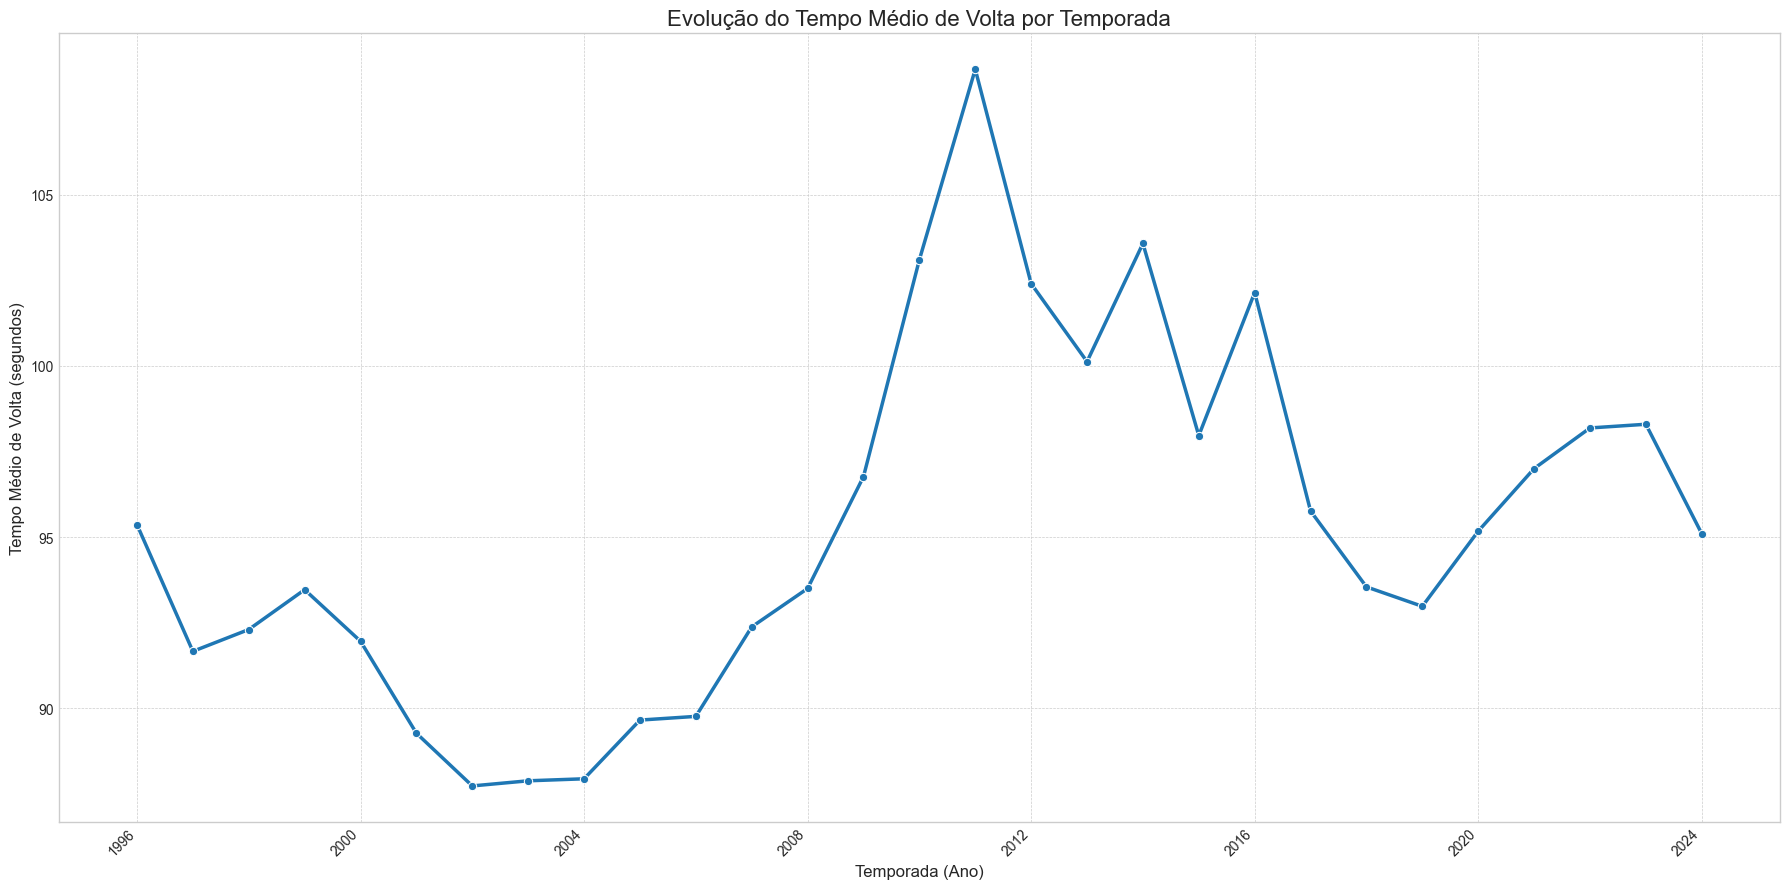

In [ ]:
from pyspark.sql.functions import avg, col
from matplotlib.ticker import MaxNLocator
laps_with_year = dataframes['lap_times'].join(dataframes['races'], 'raceId')
avg_time_per_season = laps_with_year.groupBy('year').agg(avg('milliseconds').alias('avg_ms')).withColumn('avg_s', col('avg_ms') / 1000).orderBy('year')
plot_data_15 = avg_time_per_season.toPandas()
plt.figure(figsize=(18, 9))
ax = sns.lineplot(data=plot_data_15, x='year', y='avg_s', marker='o', linewidth=2.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45, ha='right')
plt.title('Evolução do Tempo Médio de Volta por Temporada', fontsize=16)
plt.xlabel('Temporada (Ano)', fontsize=12)
plt.ylabel('Tempo Médio de Volta (segundos)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Detecção de voltas outlier


- **Objetivo do gráfico:** Identificar voltas anormalmente lentas e quantificar quais pilotos mais sofreram com essas ocorrências.
- **Dados utilizados:** `lap_times` para médias e desvios por corrida, além de `drivers` e `races` para enriquecer os detalhes.
- **Ações principais:** Calcula média e desvio padrão por corrida, define limite de outlier (média + 2 desvios), filtra voltas acima do limiar, adiciona nomes e evento, agrupa por piloto e monta a tabela das 20 piores voltas.
- **Saída:** Gráfico `Contagem de Voltas "Outlier" (Muito Lentas) por Piloto` e tabela formatada `Top 20 Voltas Mais Lentas`.
- **Insight esperado:** Evidenciar pilotos e corridas onde ocorreram problemas significativos (falhas mecânicas, incidentes, penalidades).
- **Uso prático:** Apoiar relatórios de corrida destacando momentos críticos e avaliar confiabilidade de pilotos/equipes.


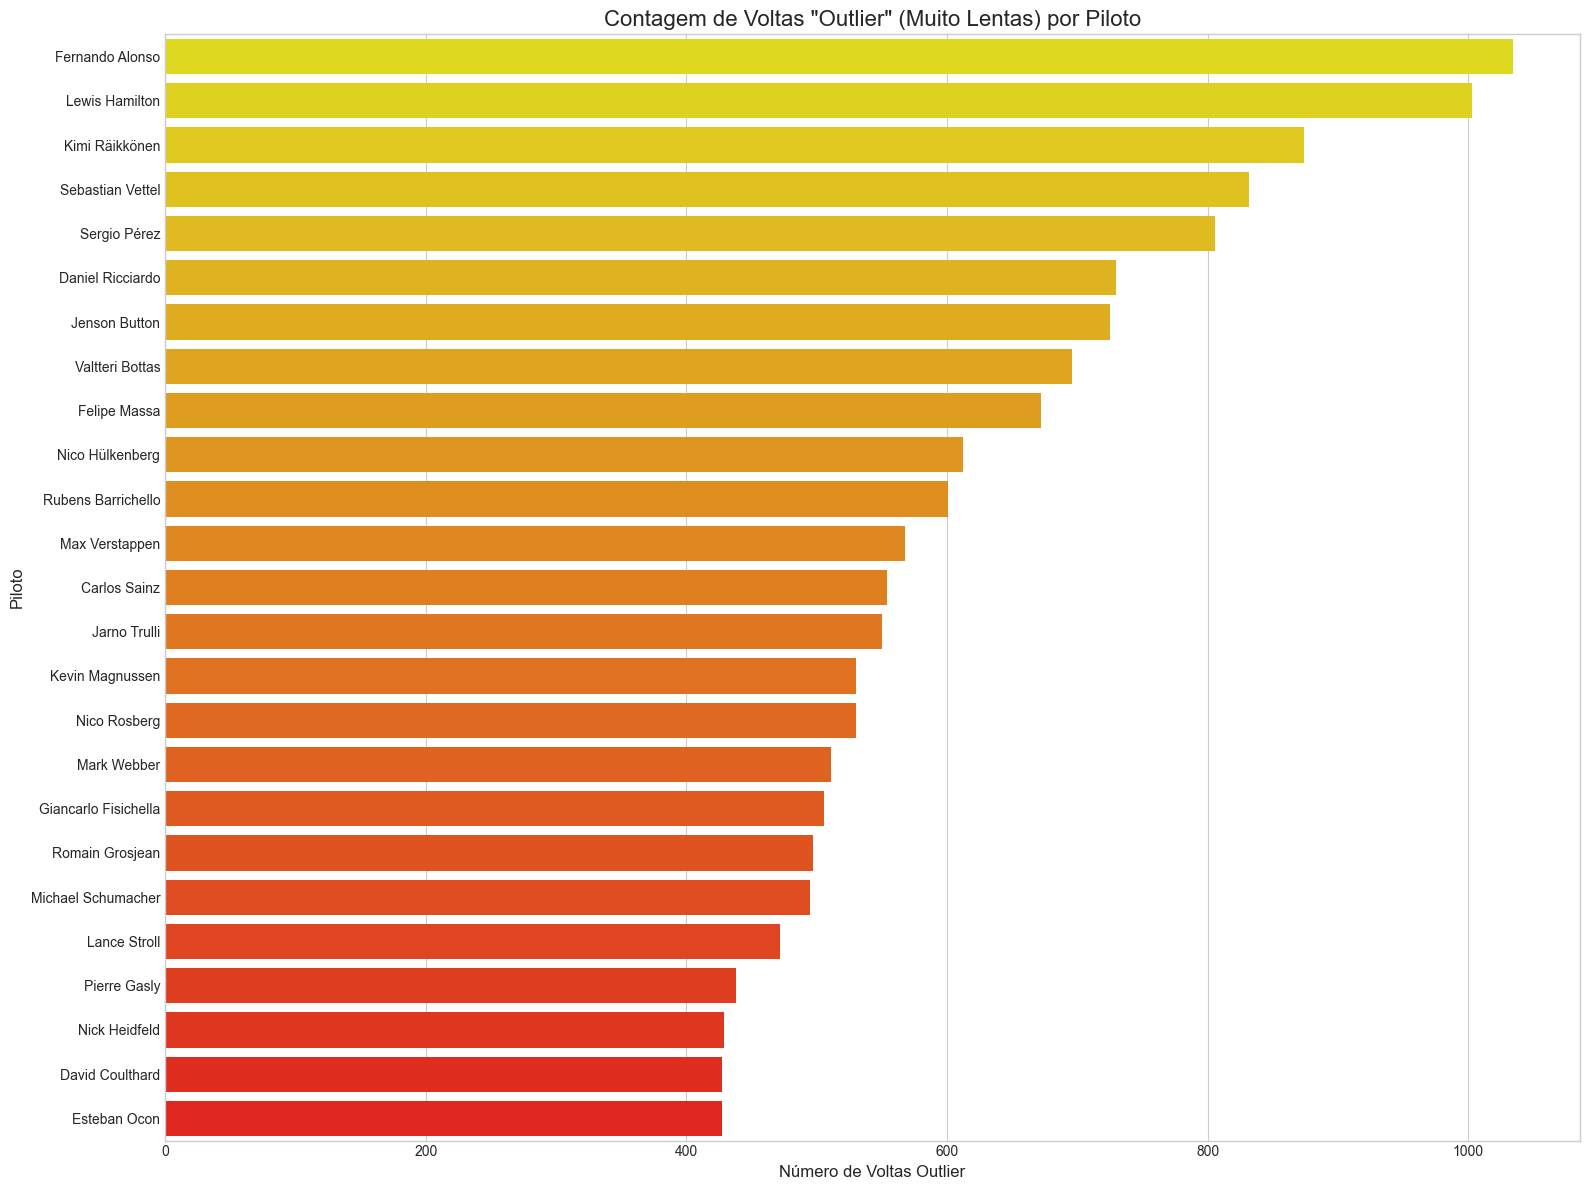


--- Top 20 Voltas Mais Lentas (em relação à média da corrida) ---


,race_event,driver_name,lap,lap_time_s,race_avg_s,slower_by_s
0,Canadian Grand Prix 2011,Nick Heidfeld,25,"7,507.55s",220.45s,"+7,287.10s"
1,Canadian Grand Prix 2011,Felipe Massa,25,"7,506.66s",220.45s,"+7,286.21s"
2,Canadian Grand Prix 2011,Vitaly Petrov,25,"7,506.24s",220.45s,"+7,285.79s"
3,Canadian Grand Prix 2011,Kamui Kobayashi,25,"7,506.10s",220.45s,"+7,285.64s"
4,Canadian Grand Prix 2011,Sebastian Vettel,25,"7,505.15s",220.45s,"+7,284.70s"
5,Canadian Grand Prix 2011,Mark Webber,25,"7,505.03s",220.45s,"+7,284.58s"
6,Canadian Grand Prix 2011,Fernando Alonso,25,"7,504.23s",220.45s,"+7,283.78s"
7,Canadian Grand Prix 2011,Paul di Resta,25,"7,503.98s",220.45s,"+7,283.53s"
8,Canadian Grand Prix 2011,Pedro de la Rosa,25,"7,503.80s",220.45s,"+7,283.34s"
9,Canadian Grand Prix 2011,Jenson Button,25,"7,503.77s",220.45s,"+7,283.32s"


In [ ]:
from pyspark.sql.functions import avg, stddev, col, count, concat_ws
race_stats = dataframes['lap_times'].groupBy('raceId').agg(avg('milliseconds').alias('avg_ms_race'), stddev('milliseconds').alias('stddev_ms_race'))
laps_with_stats = dataframes['lap_times'].join(race_stats, 'raceId')
outlier_threshold = col('avg_ms_race') + 2 * col('stddev_ms_race')
outlier_laps = laps_with_stats.filter(col('milliseconds') > outlier_threshold)
drivers_with_label = dataframes['drivers'].withColumn('driver_name', concat_ws(' ', col('forename'), col('surname')))
races_with_label = dataframes['races'].withColumn('race_event', concat_ws(' ', col('name'), col('year')))
outliers_with_details = outlier_laps.join(drivers_with_label, 'driverId').join(races_with_label, 'raceId').withColumn('lap_time_s', col('milliseconds') / 1000).withColumn('race_avg_s', col('avg_ms_race') / 1000).withColumn('slower_by_s', (col('milliseconds') - col('avg_ms_race')) / 1000).orderBy(col('slower_by_s').desc())
outlier_counts_per_driver = outliers_with_details.groupBy('driver_name').agg(count('*').alias('outlier_count')).orderBy(col('outlier_count').desc())
plot_data_16 = outlier_counts_per_driver.toPandas()
plt.figure(figsize=(16, 12))
sns.barplot(data=plot_data_16.head(25), x='outlier_count', y='driver_name', orient='h', palette='autumn_r', hue='driver_name', legend=False)
plt.title('Contagem de Voltas "Outlier" (Muito Lentas) por Piloto', fontsize=16)
plt.xlabel('Número de Voltas Outlier', fontsize=12)
plt.ylabel('Piloto', fontsize=12)
plt.tight_layout()
plt.show()
top_20_outliers_pd = outliers_with_details.select('race_event', 'driver_name', 'lap', 'lap_time_s', 'race_avg_s', 'slower_by_s').limit(20).toPandas()
print('\n--- Top 20 Voltas Mais Lentas (em relação à média da corrida) ---')
top_20_outliers_pd['lap_time_s'] = top_20_outliers_pd['lap_time_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['race_avg_s'] = top_20_outliers_pd['race_avg_s'].map('{:,.2f}s'.format)
top_20_outliers_pd['slower_by_s'] = top_20_outliers_pd['slower_by_s'].map('+{:,.2f}s'.format)
display(top_20_outliers_pd)
